In [40]:
import numpy as np
import matplotlib.pyplot as plt

import skimage as sk

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import random


# Create Dummy CSD

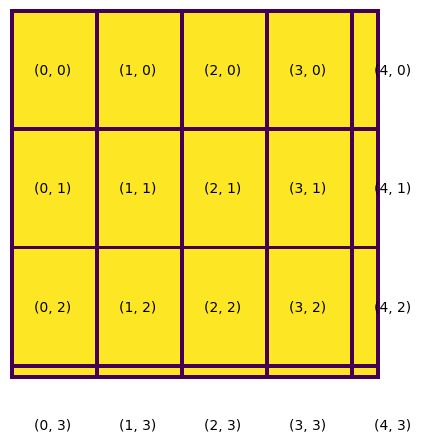

In [41]:

# Create a blank image with a grid of 100x100
grid_size = 100
image = np.ones((grid_size, grid_size), dtype=np.uint8) * 255

horizontal_spacing = np.random.randint(20,30)
vertical_spacing = np.random.randint(20,40)

image[:, 0] = 0
image[:, -1] = 0
image[0, :] = 0
image[-1, :] = 0


image[:,horizontal_spacing::horizontal_spacing] = 0
image[vertical_spacing::vertical_spacing, :] = 0


# Label each block accordingly
for i in range(0, grid_size, vertical_spacing):
    for j in range(0, grid_size, horizontal_spacing):
        x_label = j // horizontal_spacing
        y_label = i // vertical_spacing
        label = (x_label, y_label)
        label = f"({x_label}, {y_label})"
        plt.text(j + horizontal_spacing//2, i + vertical_spacing//2, label, color='black',
                 ha='center', va='center')

# Display the resulting image
plt.imshow(image)
plt.axis('off')
plt.show()

# Apply affine transformation
# import cv2
# # access the image height and width
# rows,cols = image.shape

# M = np.array([[1, np.tan(np.radians(10)),0], [0,1,0]])

# # apply affine transformation on the input image
# image = cv2.warpAffine(image,M,(cols,rows))

# # Label each block accordingly
# for i in range(0, grid_size, vertical_spacing):
#     for j in range(0, grid_size, horizontal_spacing):
#         x_label = j // horizontal_spacing
#         y_label = i // vertical_spacing
#         label = (x_label, y_label)
#         label = f"({x_label}, {y_label})"
#         plt.text(j + horizontal_spacing//2, i + vertical_spacing//2, label, color='black',
#                  ha='center', va='center')
# # Display the resulting image
# plt.imshow(image)
# plt.axis('off')
# plt.show()


# Break into Polygons

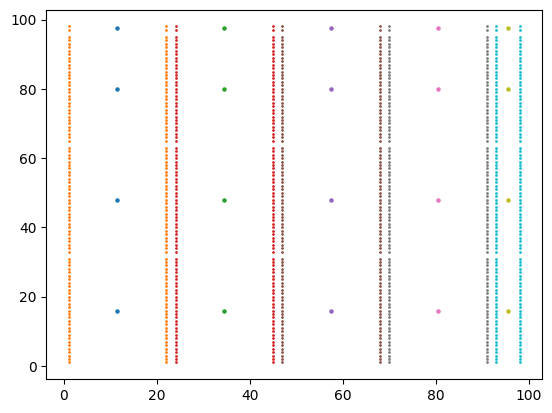

In [42]:
image_labelled = sk.measure.label(image, connectivity=1)

image_regions = sk.measure.regionprops(image_labelled)

centroid_list = []
for index in range(len(image_regions)):
    region_info = {}

    region_coords = image_regions[index].coords

    # Get boundaries of coordiantes
    temp = {}
    for row in region_coords:
        key = row[0]
        value = row[1]
        if key not in temp:
            temp[key] = [value, value]  # Initialize with the current value
        else:
            temp[key][0] = min(temp[key][0], value)  # Update minimum value
            temp[key][1] = max(temp[key][1], value)  # Update maximum value
    region_coords = np.array([[key, minmax[0]] for key, minmax in temp.items()] + [[key, minmax[1]] for key, minmax in temp.items()])

    y,x = region_coords.T

    px = x.tolist()
    py = y.tolist()

    def flip_coordinates_horizontal_axis(x_coordinates, y_coordinates, axis):
        flipped_x_coordinates = []
        flipped_y_coordinates = []
        
        for x, y in zip(x_coordinates, y_coordinates):
            distance = (axis - y)
            y_flipped = axis + distance
            flipped_x_coordinates.append(x)
            flipped_y_coordinates.append(y_flipped)
        
        return flipped_x_coordinates, flipped_y_coordinates

    def find_polygon_centroid(coordinates):

        n = len(coordinates)
        
        # Calculate the signed area of the polygon
        signed_area = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            signed_area += (x_i * y_j - x_j * y_i)
        signed_area *= 0.5
        
        # Calculate the coordinates of the centroid
        centroid_x = 0
        centroid_y = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            factor = x_i * y_j - x_j * y_i
            centroid_x += (x_i + x_j) * factor
            centroid_y += (y_i + y_j) * factor
        centroid_x /= (6 * signed_area)
        centroid_y /= (6 * signed_area)
        
        return centroid_x, centroid_y

    def organize_array_clockwise(arr):
            
        # Calculate the centroid of the points
        centroid = np.mean(arr, axis=0)

        # Calculate the angle of each point with respect to the centroid
        angles = np.arctan2(arr[:, 1] - centroid[1], arr[:, 0] - centroid[0])

        # Sort the points based on the angles in clockwise order
        indices = np.argsort(angles)
        sorted_arr = arr[indices]

        return sorted_arr      

    poly = [(x, y) for x, y in zip(px, py)]
    poly = np.array([p for x in poly for p in x]).reshape(-1,2)
    
    poly_clockwise = organize_array_clockwise(poly)
    x0, y0 = find_polygon_centroid(poly_clockwise)
    x0_, y0_ = flip_coordinates_horizontal_axis([x0], [y0], axis=image.shape[0]/2)
    x0_, y0_ = flip_coordinates_horizontal_axis(y0_, x0_, axis=image.shape[1]/2)
    x0_val, y0_val = x0_[0], y0_[0]

    plt.scatter([x0],[y0], s=5)
    plt.scatter(px,py, s=1)
    centroid_list.append([x0,y0])

points = np.array(centroid_list)

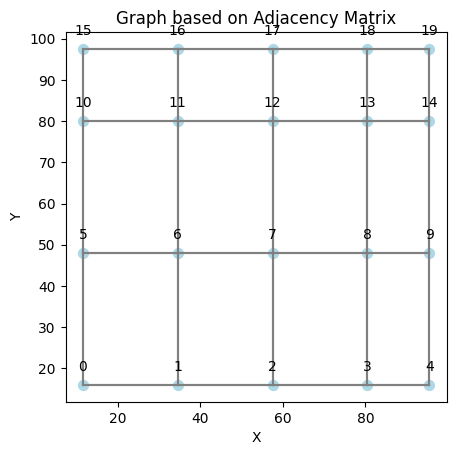

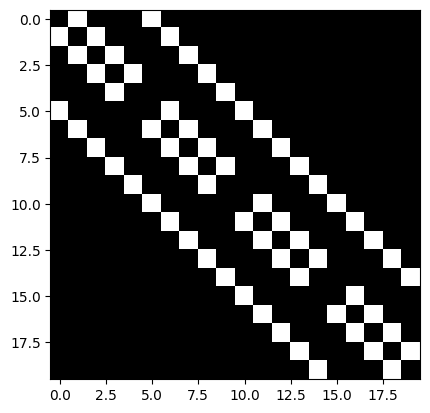

In [43]:
# Create adjacency matrix
num_of_points = points.shape[0]
adj_matrix = np.zeros((num_of_points, num_of_points))

label_coordinate_dict = {}

for i in range(num_of_points):
    for j in range(num_of_points):
        x1, y1 = points[i]
        x2, y2 = points[j]
        x1_label = x1 // horizontal_spacing
        y1_label = y1 // vertical_spacing
        label1 = (x1_label, y1_label)
        x2_label = x2 // horizontal_spacing
        y2_label = y2 // vertical_spacing
        label2 = (x2_label, y2_label)

        label_coordinate_dict[label1] = [x1,y1]
        label_coordinate_dict[label2] = [x2,y2]

        label_diff = (x1_label - x2_label, y1_label- y2_label)

        if 0 in label_diff and (1 in label_diff or -1 in label_diff):
            adj_matrix[i,j] = 1

# Plot the graph
fig, ax = plt.subplots()
# ax.imshow(csd_qd_states, cmap='gray')

ax.set_aspect('equal')
# Draw nodes
ax.scatter(points[:, 0], points[:, 1], c='lightblue', s=50)
# Add text annotations for each point
for i, point in enumerate(points):
    ax.annotate(str(i), (point[0], point[1]), textcoords="offset points",
                xytext=(0, 10), ha='center')
# Draw edges
for i in range(num_of_points):
    for j in range(num_of_points):
        if adj_matrix[i, j] == 1:

            ax.plot([points[i, 0], points[j, 0]],
                    [points[i, 1], points[j, 1]], color='gray')
            label = f"{i}, {j}"
            mid_x = (points[i, 0] + points[j, 0]) / 2
            mid_y = (points[i, 1] + points[j, 1]) / 2
            # ax.text(mid_x, mid_y, label, ha='center', va='center')

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph based on Adjacency Matrix')

# Show the plot
plt.show()

plt.imshow(adj_matrix, cmap='gray')
plt.show()
